In [206]:
import pandas as pd  
import numpy as np
from glob import glob
from scipy.io import savemat, loadmat
from datetime import datetime

import seaborn as sns
sns.reset_orig()
import matplotlib.pyplot as plt
import pdb

import psycopg2
import sqlite3
import os

from importlib import reload

import visualizeProfs as vp
reload(visualizeProfs)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pchipOceanSlices import PchipOceanSlices

#reload(visualizeProfs)

/home/tyler/anaconda3/envs/argo/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/tyler/anaconda3/envs/argo/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/tyler/anaconda3/envs/argo/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/tyler/anaconda3/envs/argo/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/tyler/anaconda3/envs/argo/lib/python3.6/_collectio

In [196]:
files = glob('/home/tyler/Kuusela-Stein/Data/Data/**/obsProfResTrendTemp_at*20.mat')
dfkeys =  ['obsProfRes', 'profFloatIDAggrSel', 'profJulDayAggrSel', 'profLatAggrSel', 'profLongAggrSel']

In [177]:
for file in files:
    print(file)
    mat = loadmat(file)
    mat['obsProfRes'] = mat['obsProfRes'][0]
    mat['profLatAggrSel'] = mat['profLatAggrSel'][0]
    mat['profLongAggrSel'] = mat['profLongAggrSel'][0]
    mat['profJulDayAggrSel'] = mat['profJulDayAggrSel'].flatten()
    mat['profFloatIDAggrSel'] = mat['profFloatIDAggrSel'].flatten()
    m = { key: mat[key] for key in dfkeys }
    dates = [pd.to_datetime(x[0]) for x in mat['strDate'].flatten()]
    df = pd.DataFrame.from_dict(m)
    df['date'] = dates

/home/tyler/Kuusela-Stein/Data/Data/10.0/obsProfResTrendTemp_at10.0dbar_5_20.mat


In [179]:
def detect_outlier(res, threshold):
    outliers=[]
    mean = np.mean(res)
    std =np.std(res)
    for idx, y in enumerate(res):
        z_score= (y - mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(idx)
    return outliers

(233, 6)


/home/tyler/anaconda3/envs/argo/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/tyler/anaconda3/envs/argo/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/tyler/anaconda3/envs/argo/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To c

/home/tyler/anaconda3/envs/argo/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/tyler/anaconda3/envs/argo/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


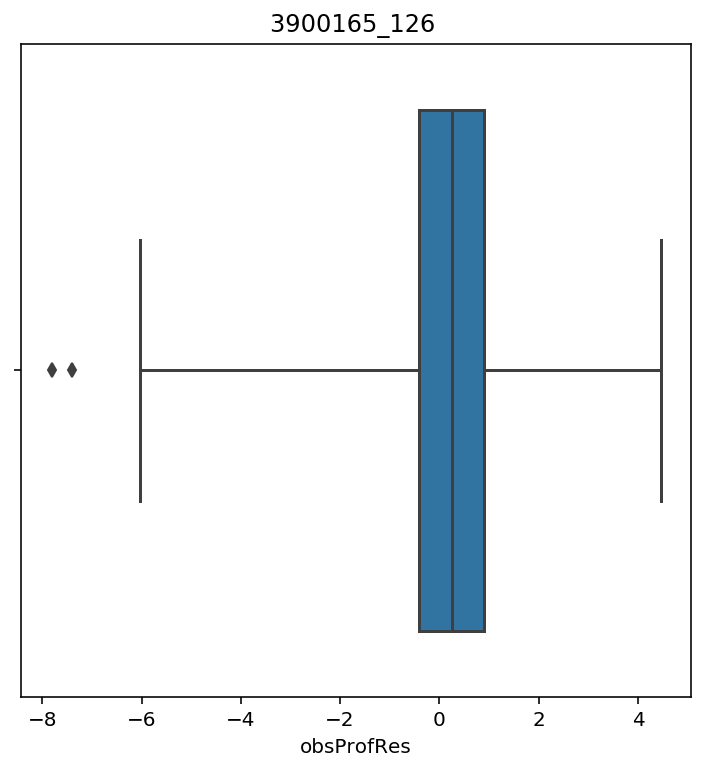

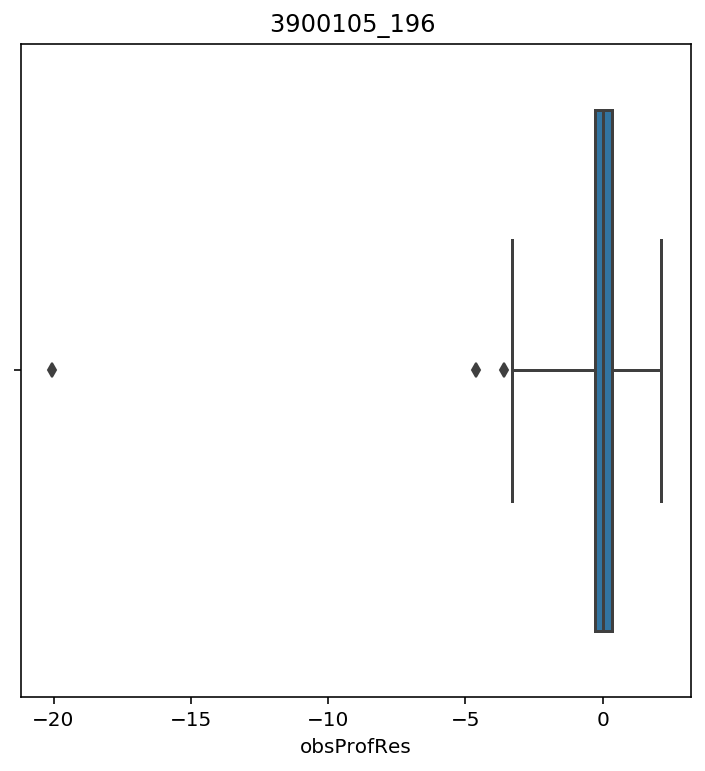

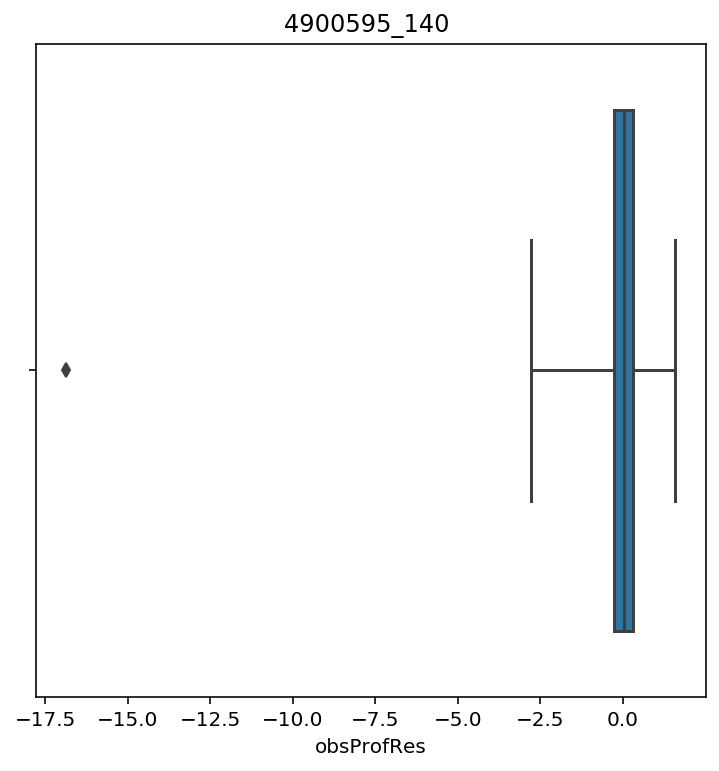

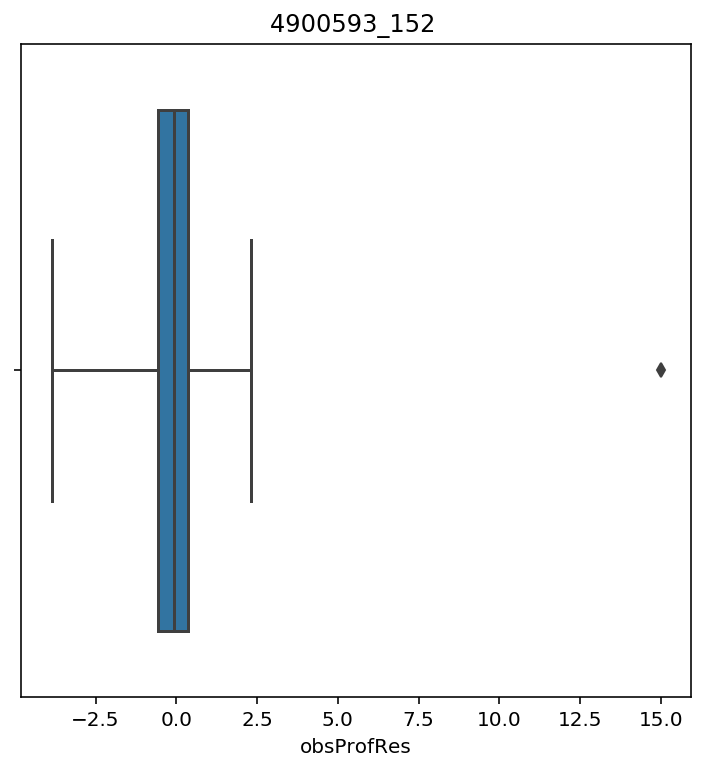

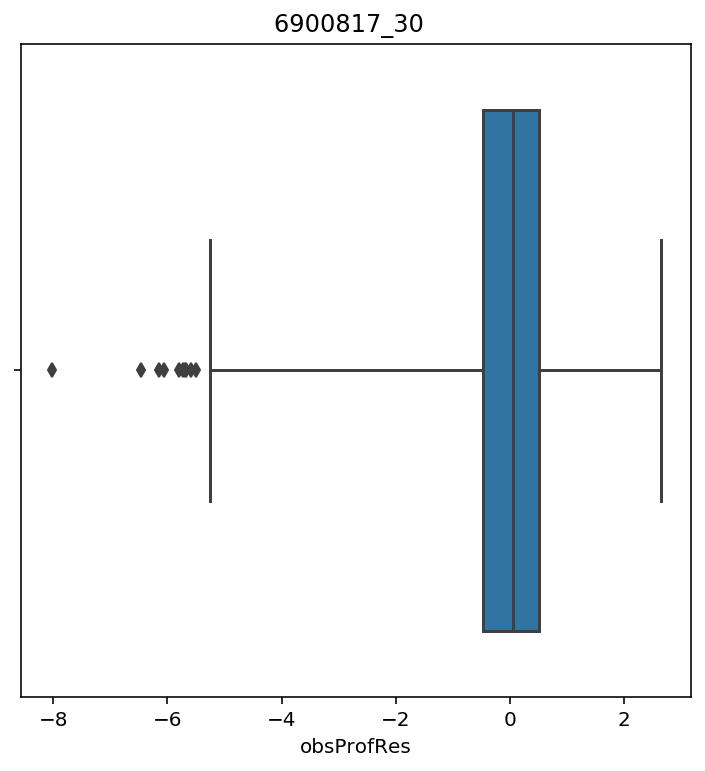

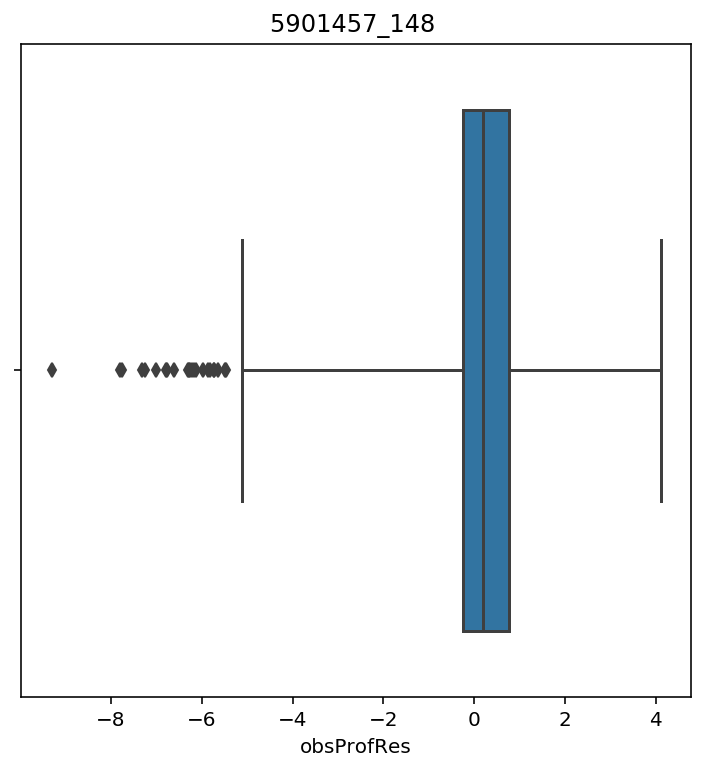

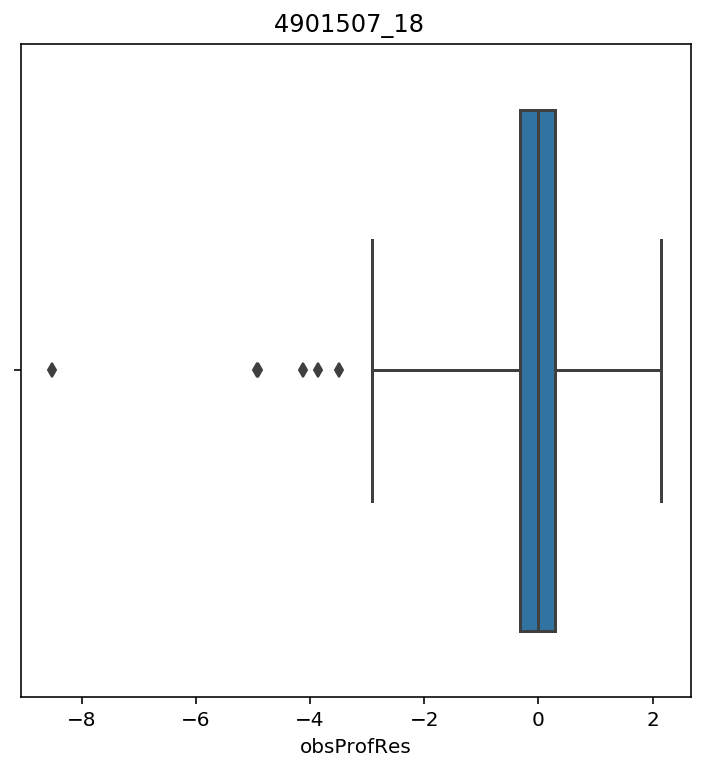

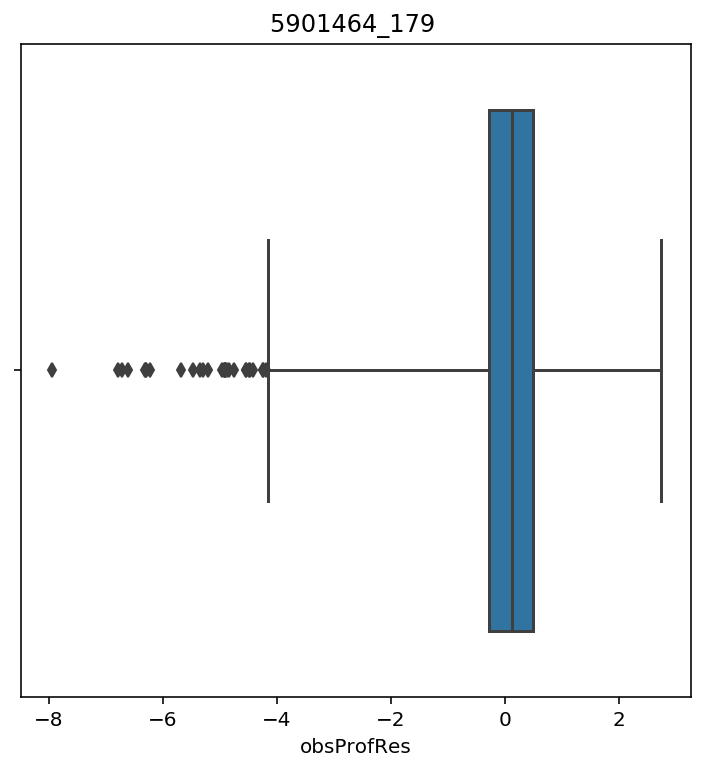

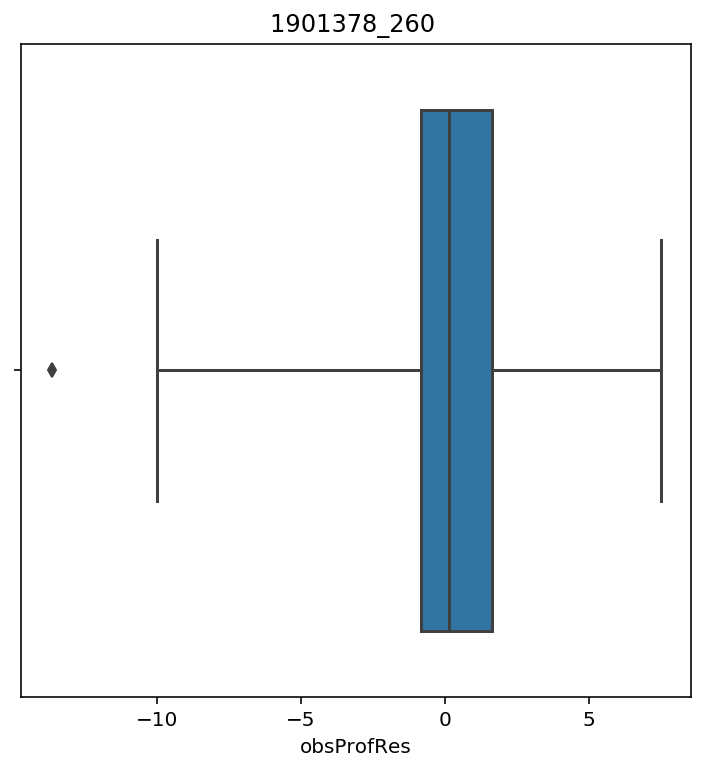

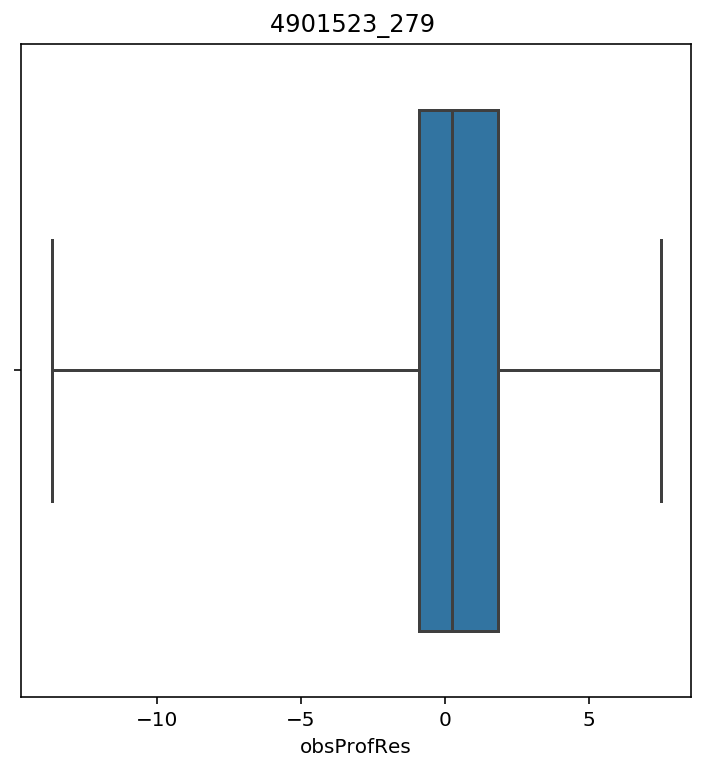

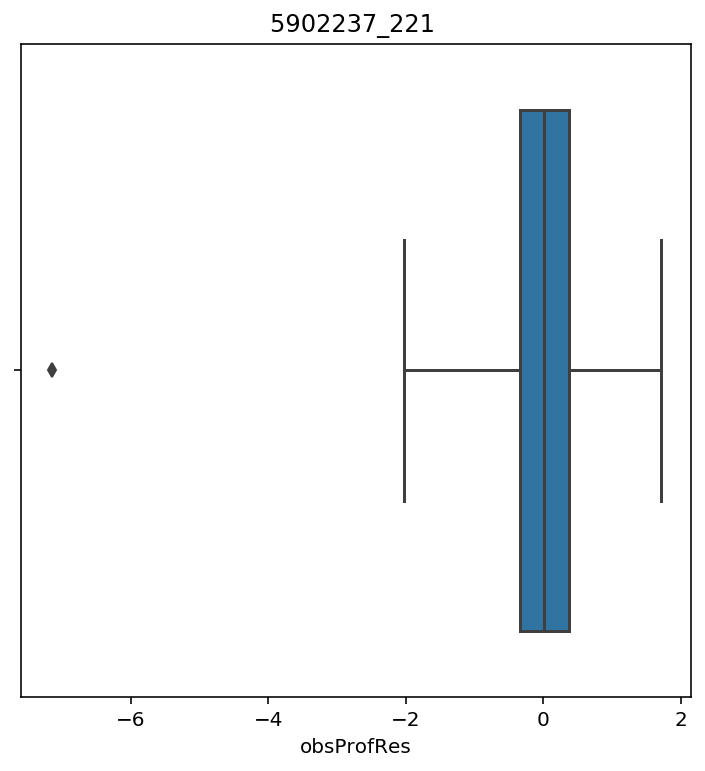

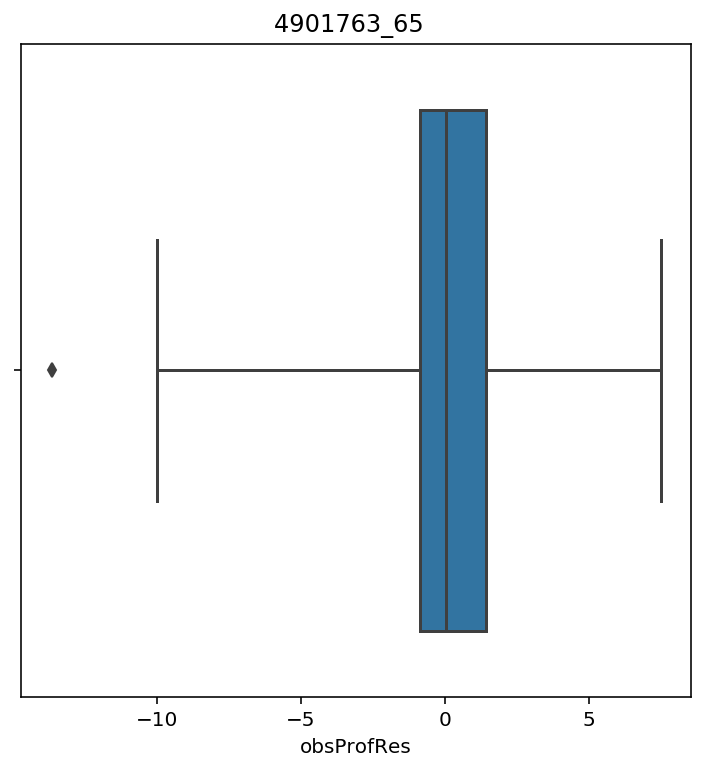

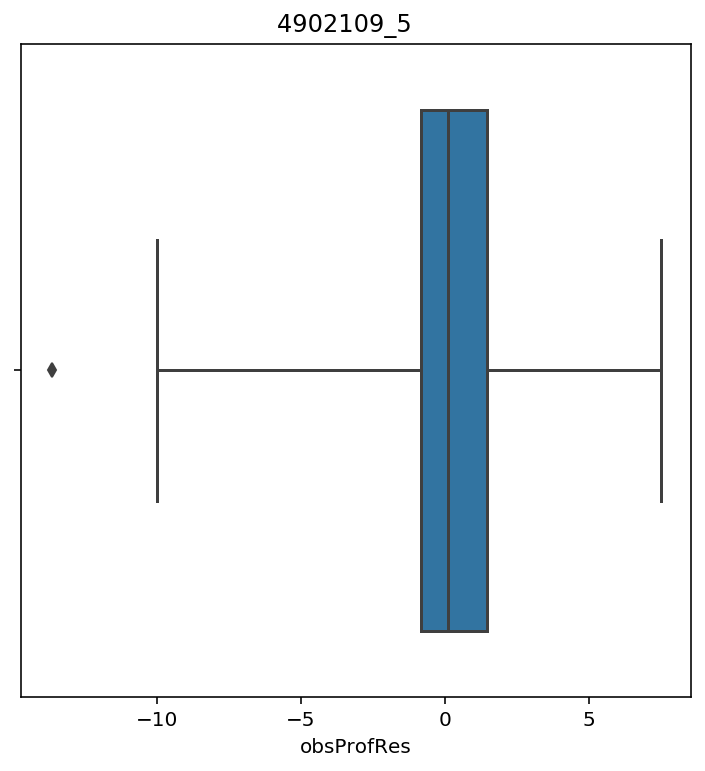

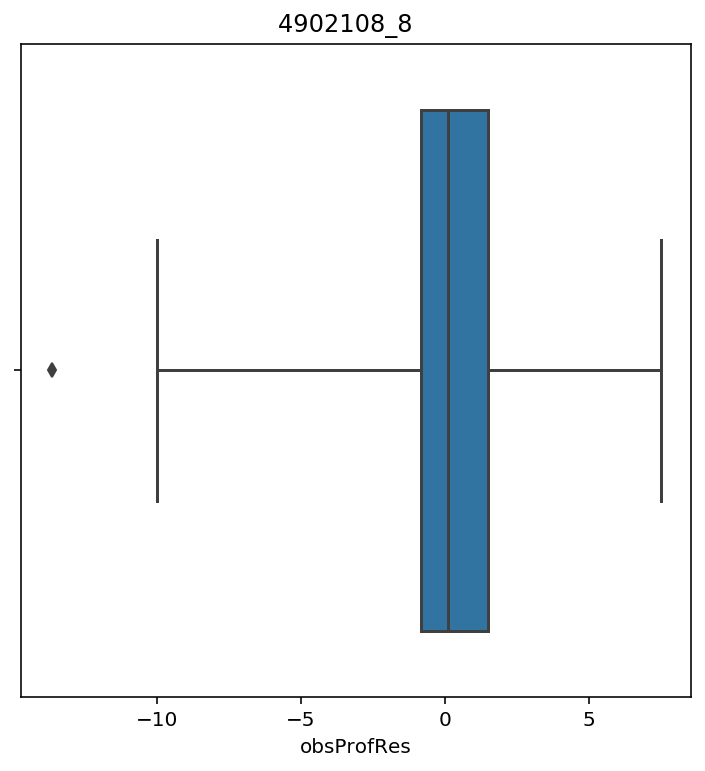

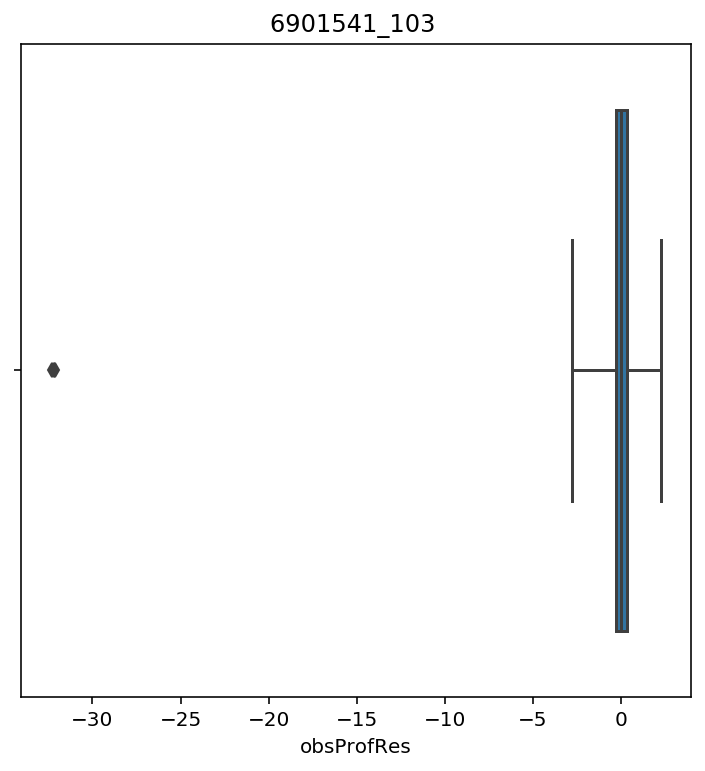

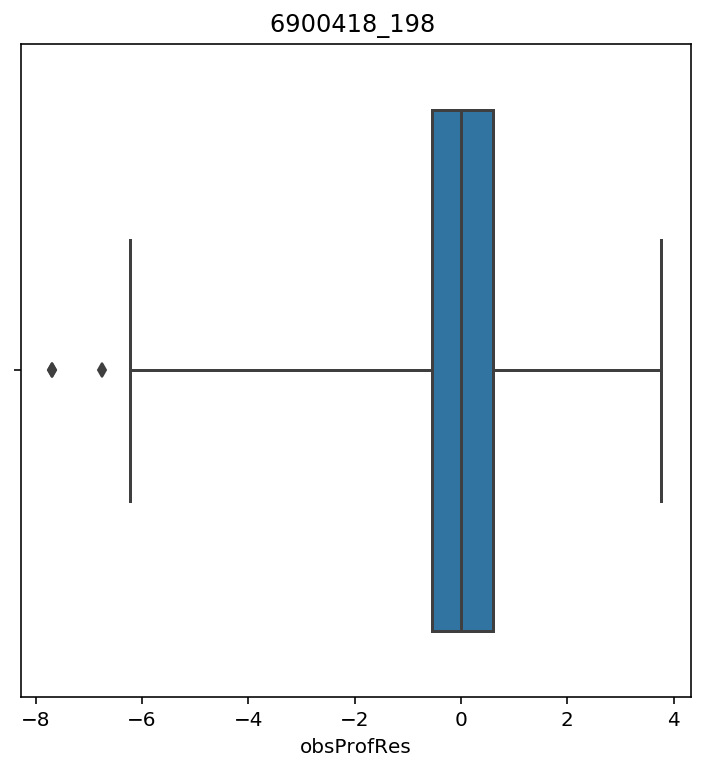

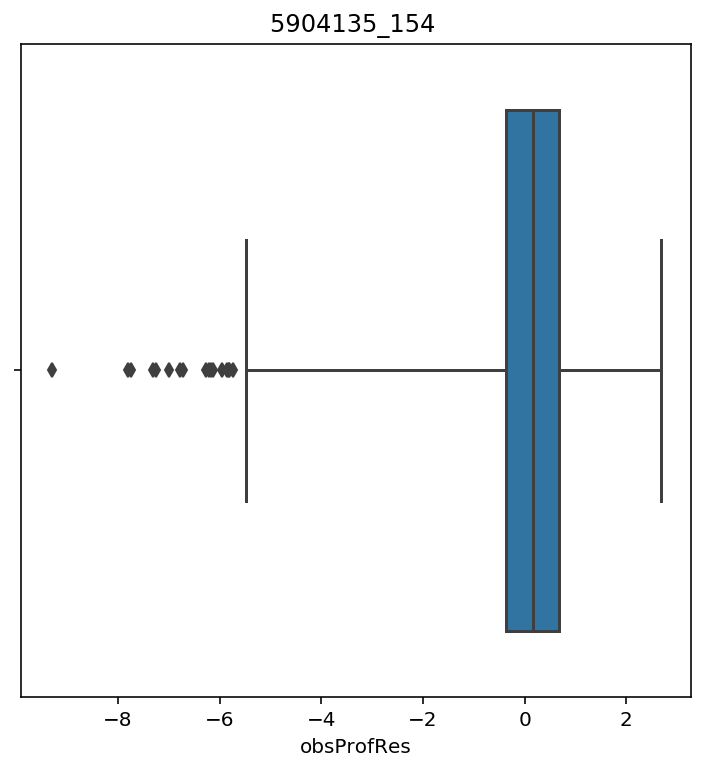

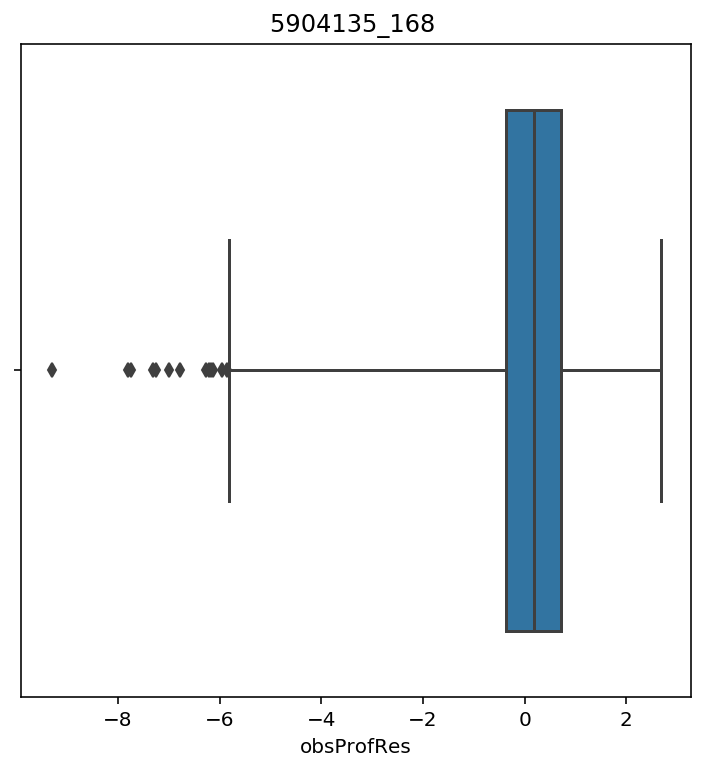

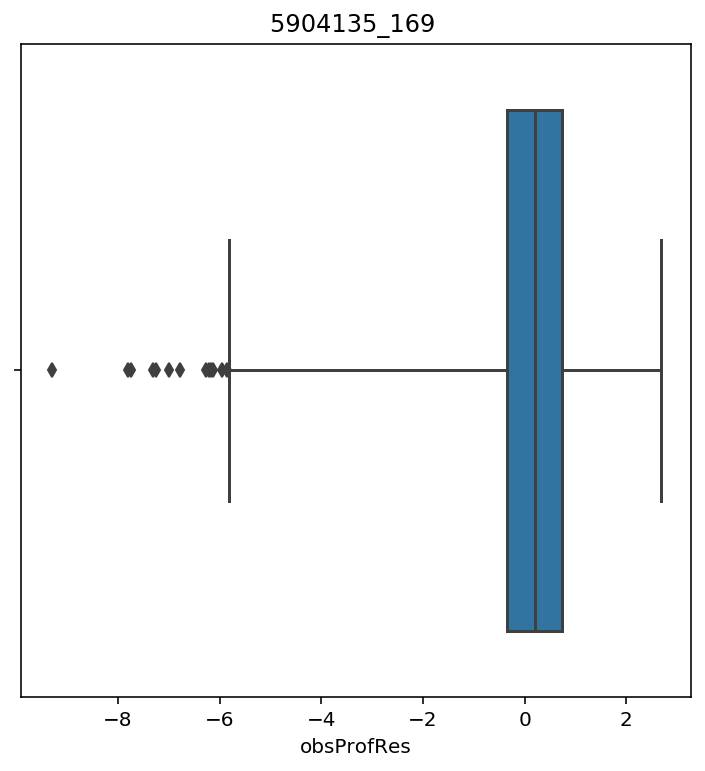

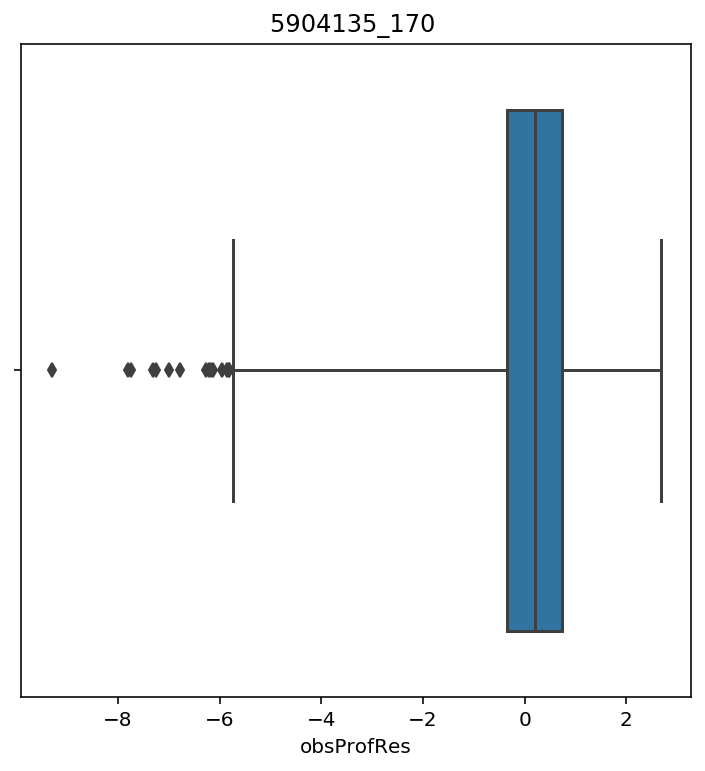

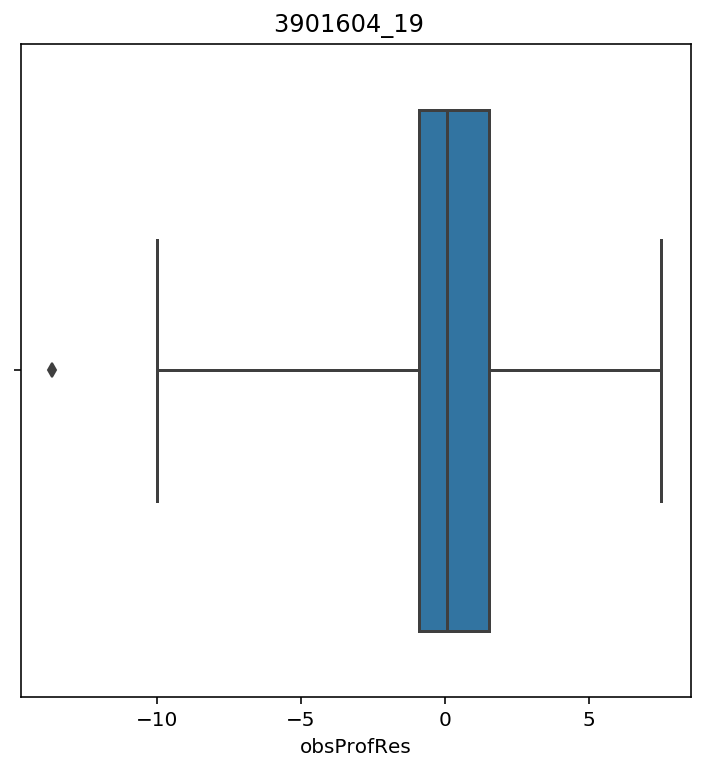

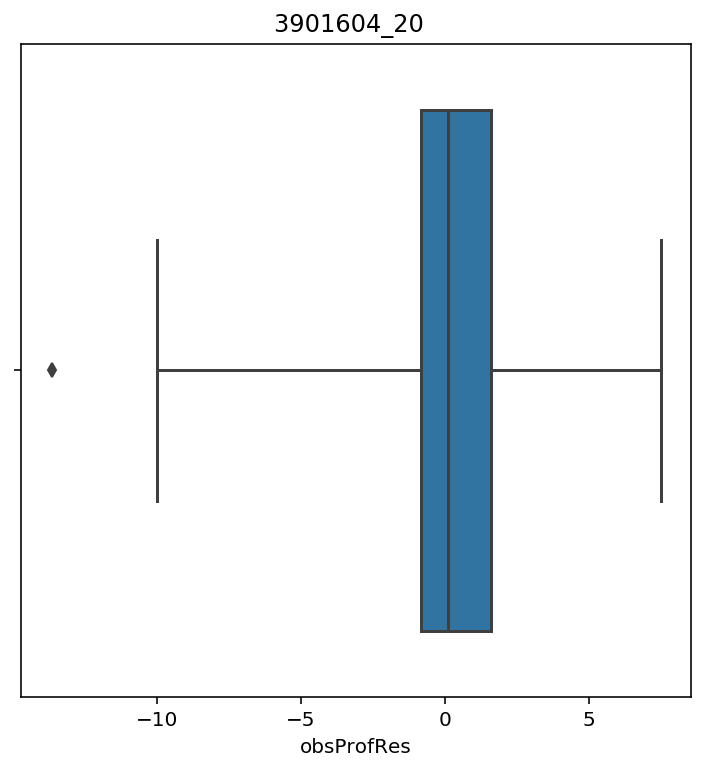

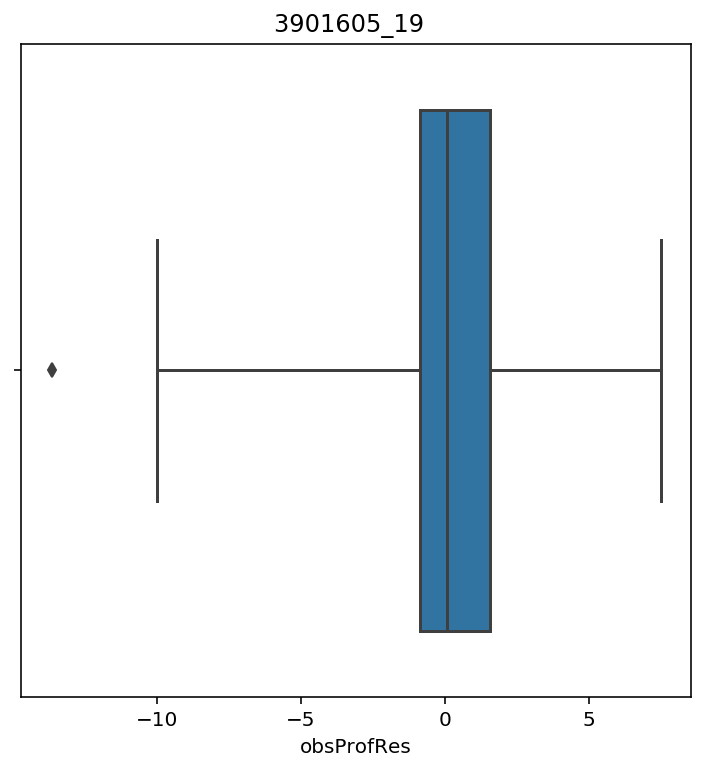

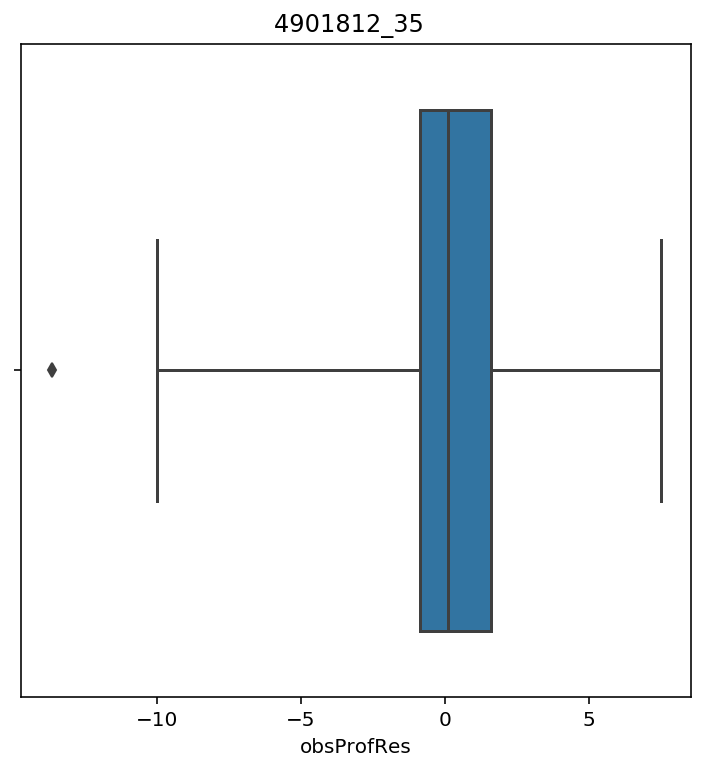

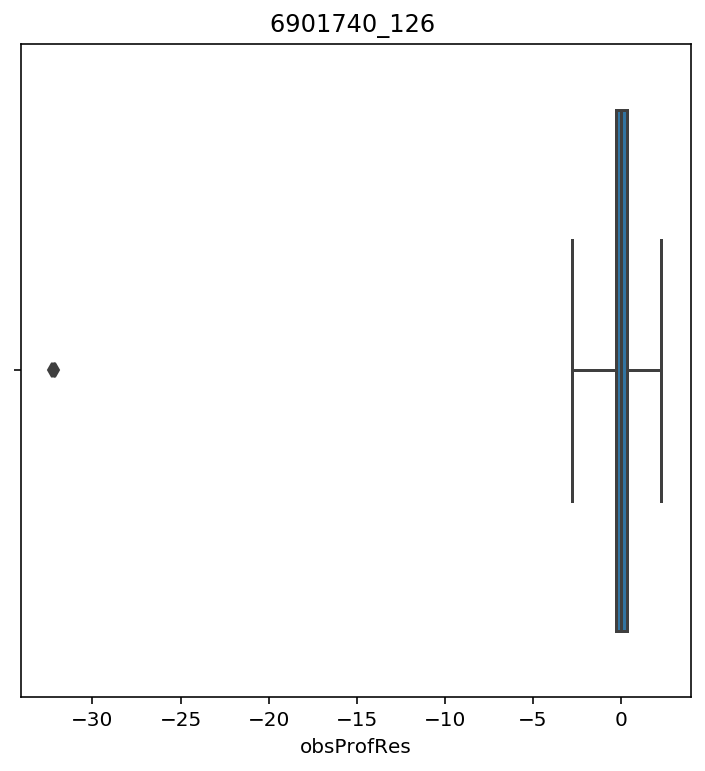

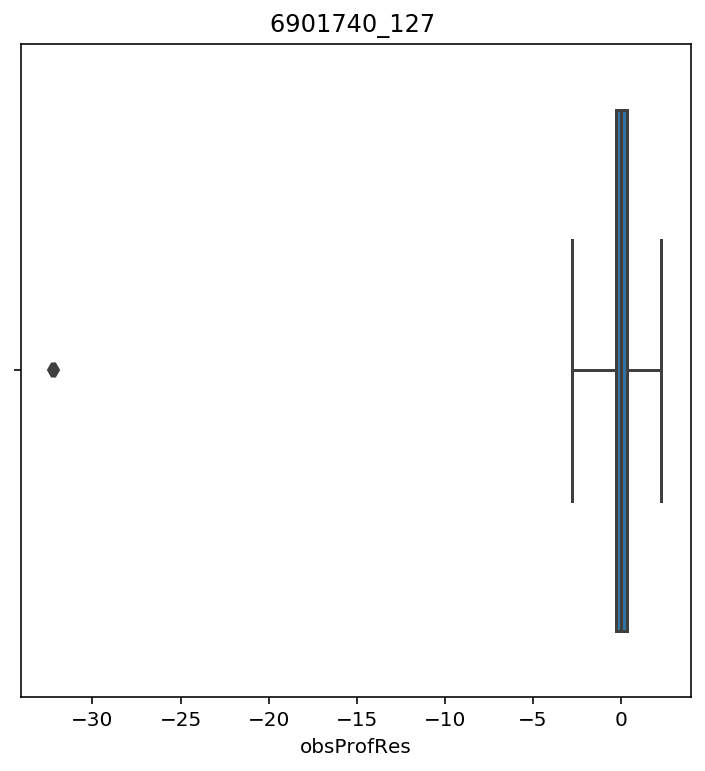

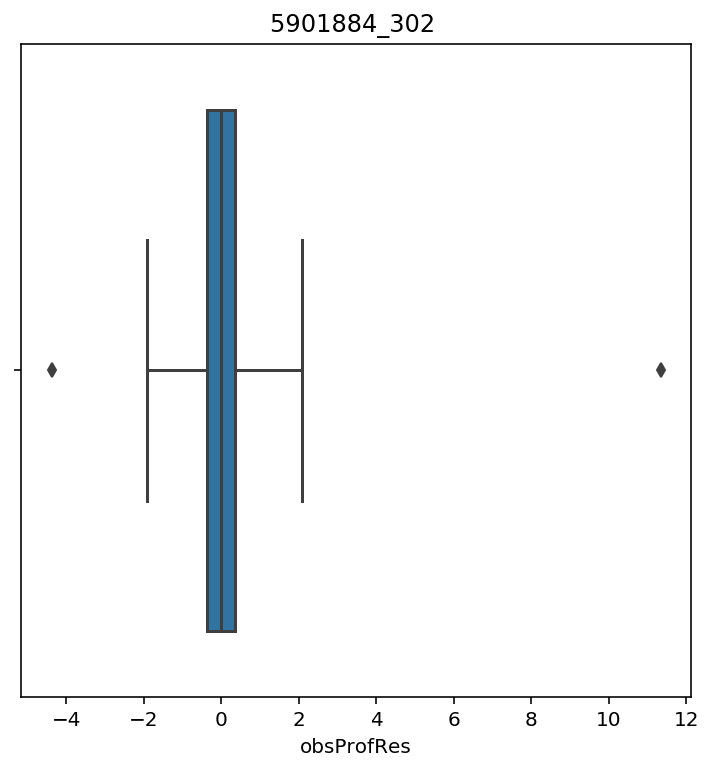

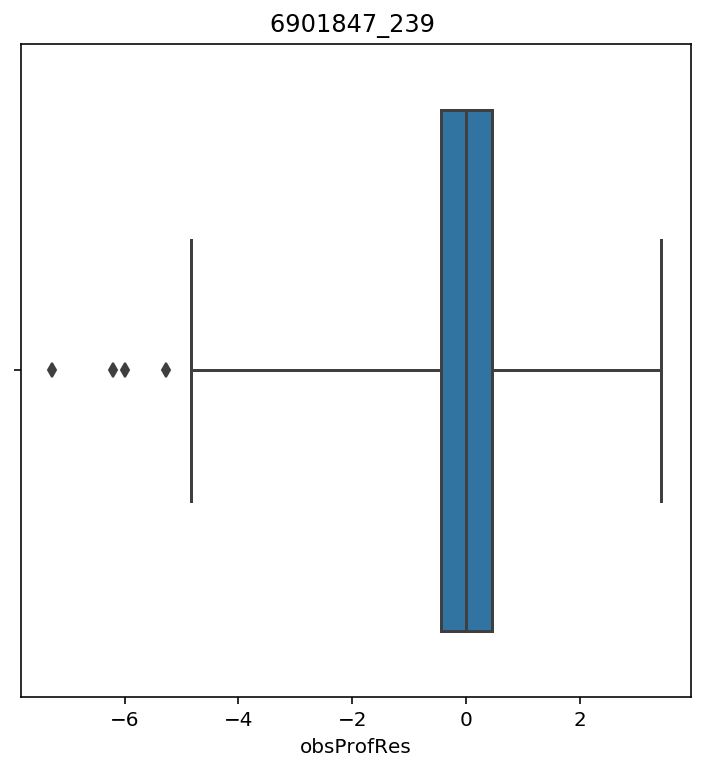

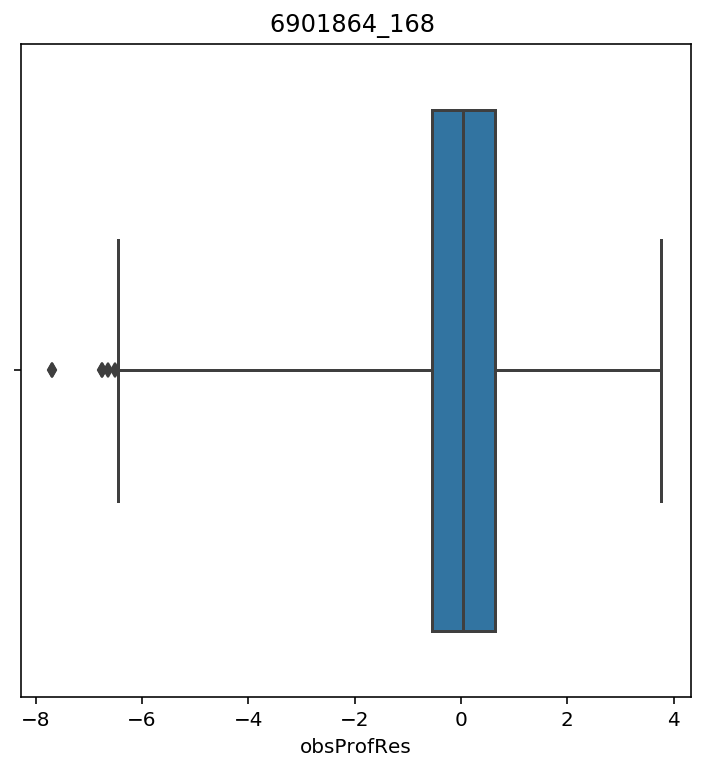

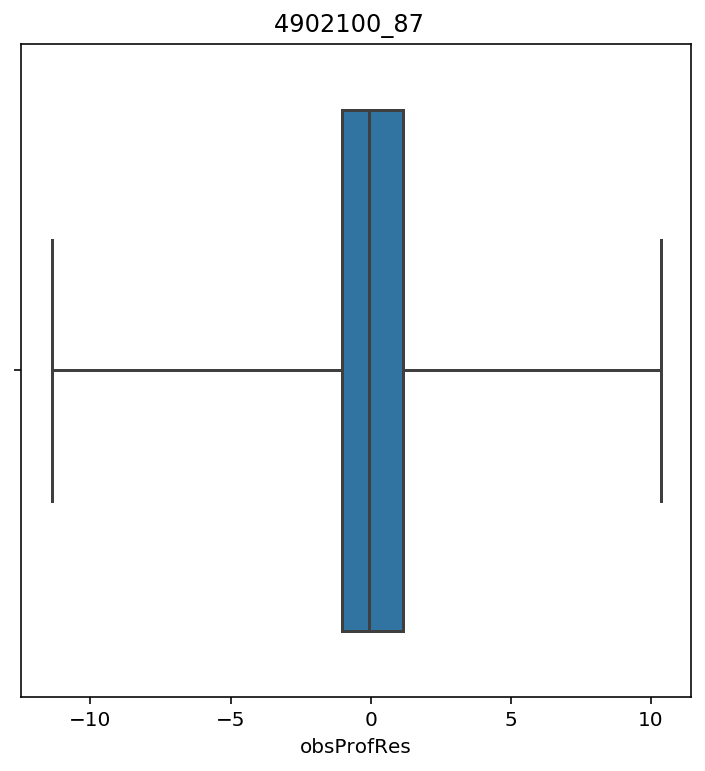

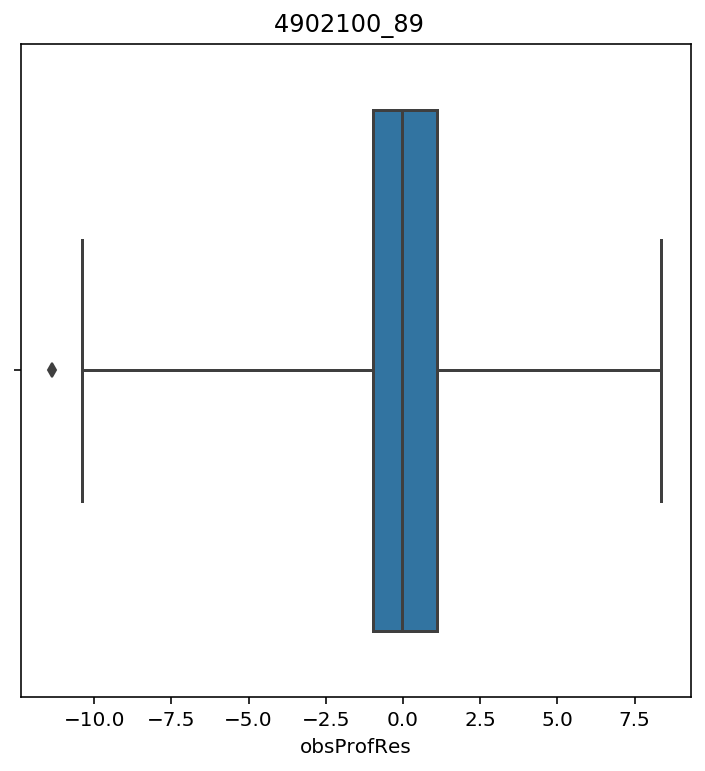

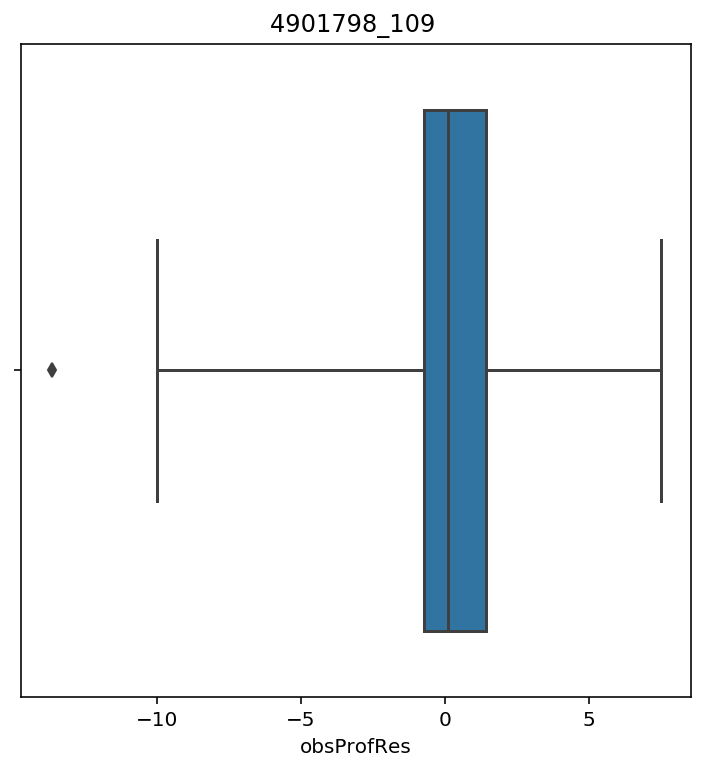

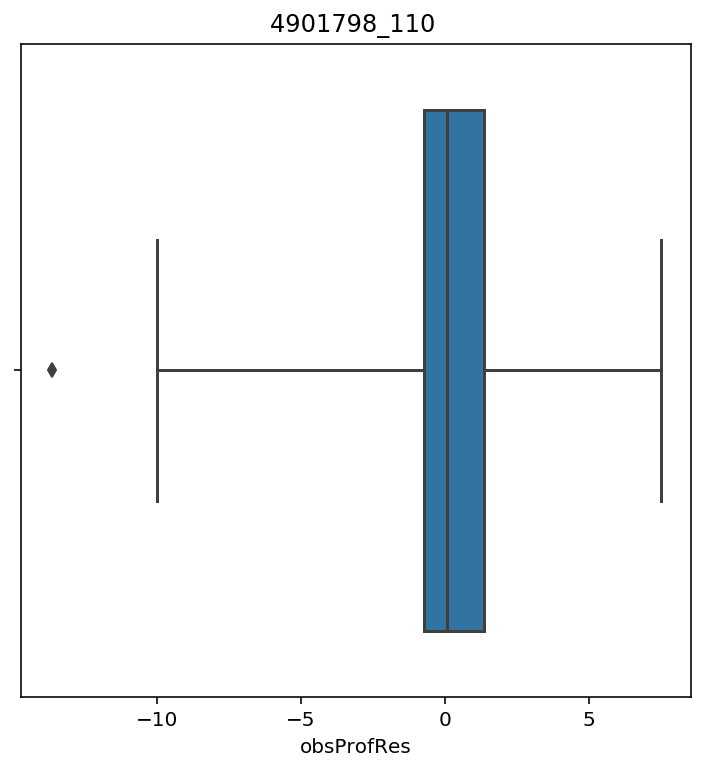

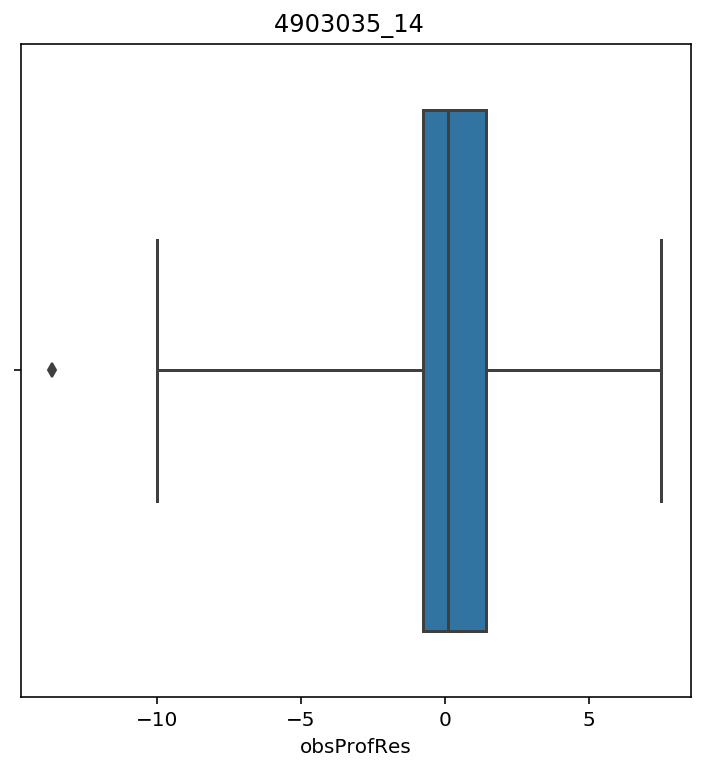

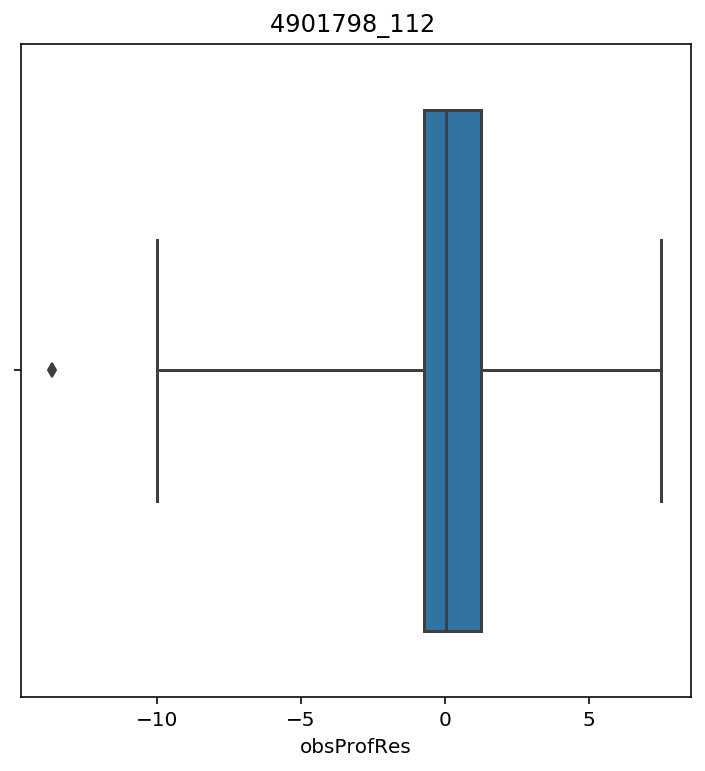

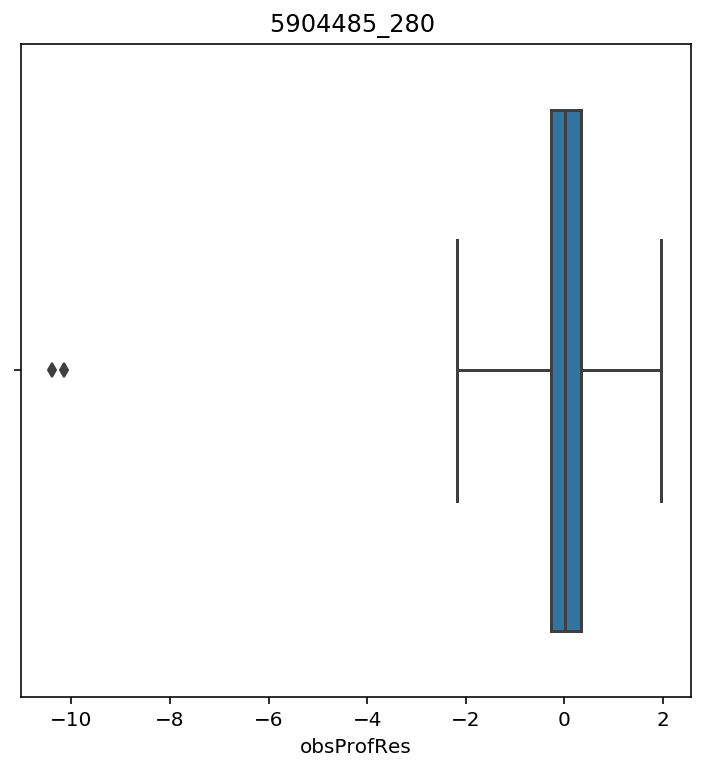

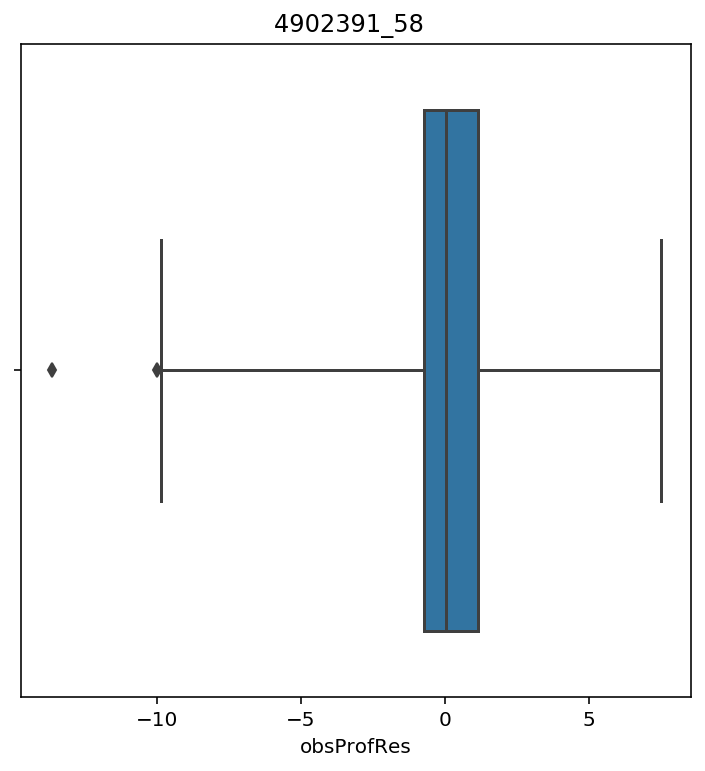

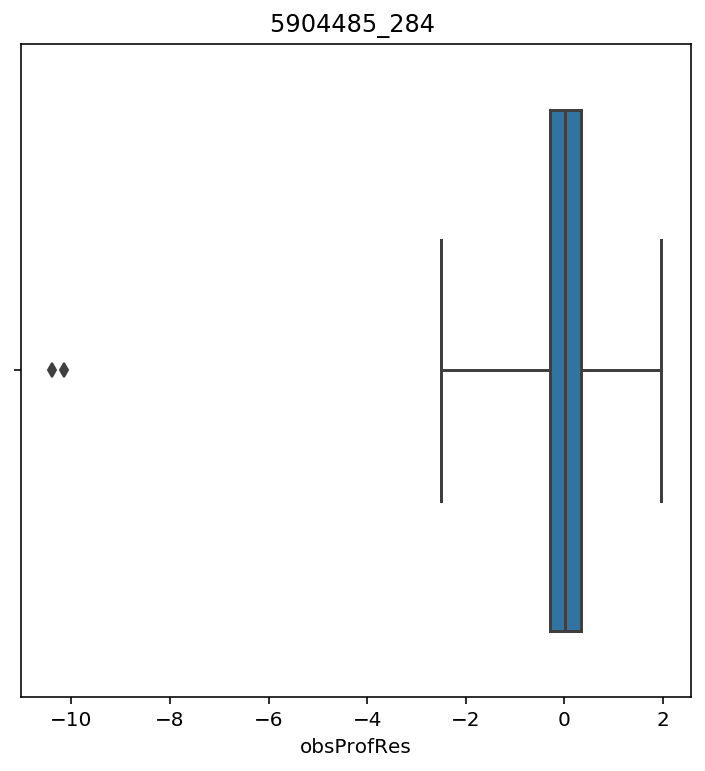

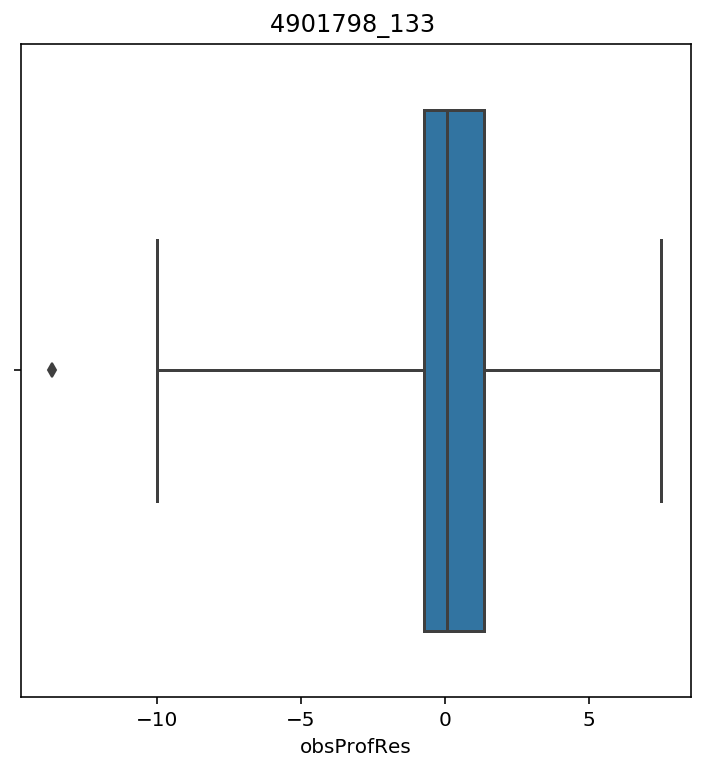

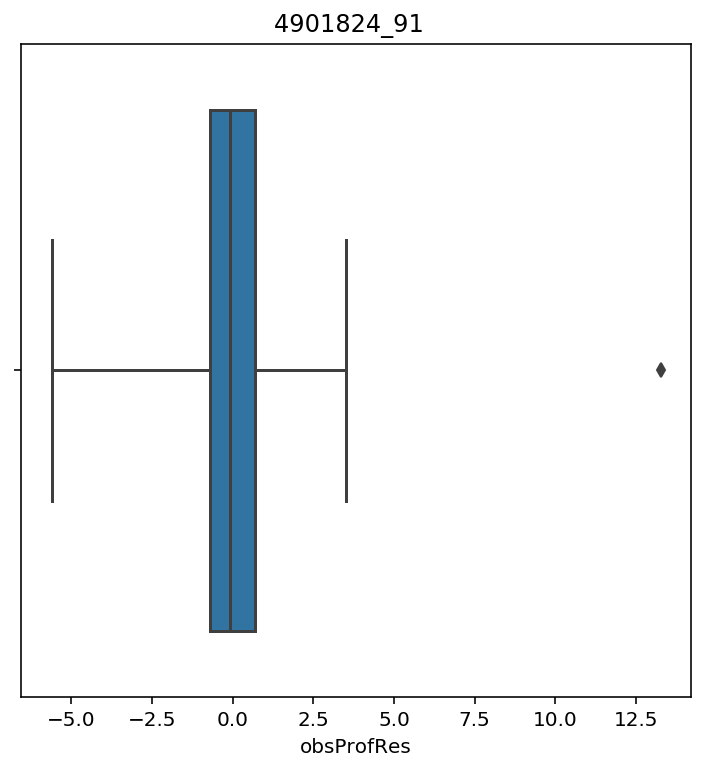

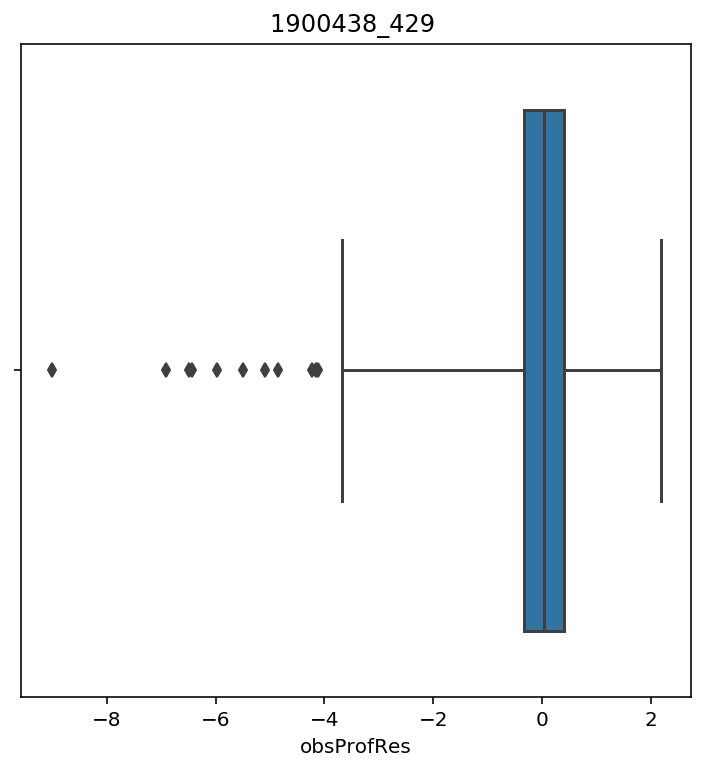

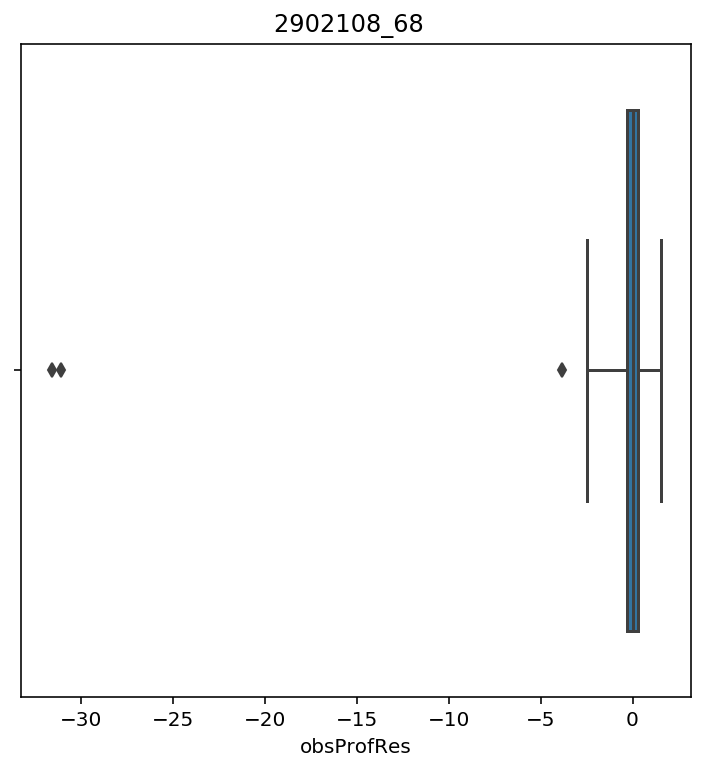

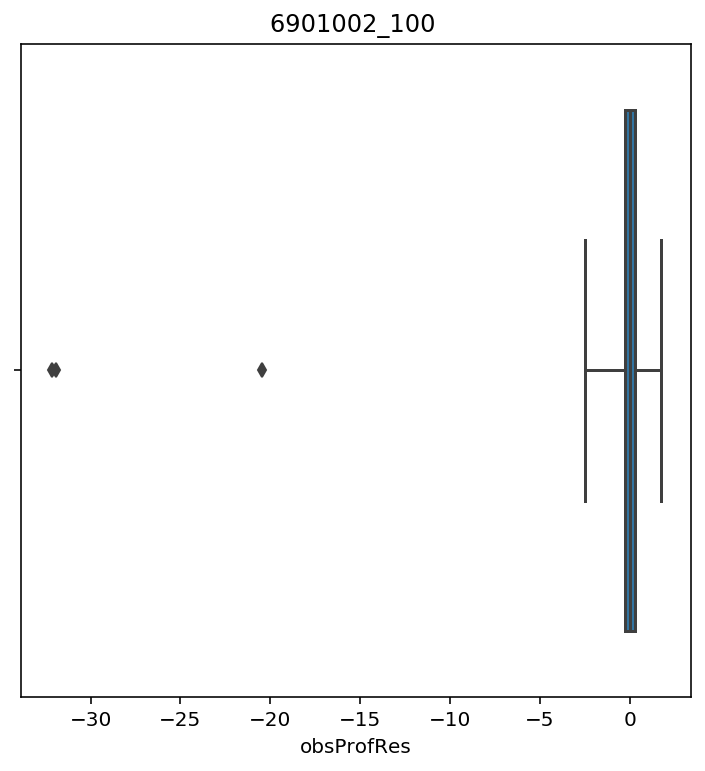

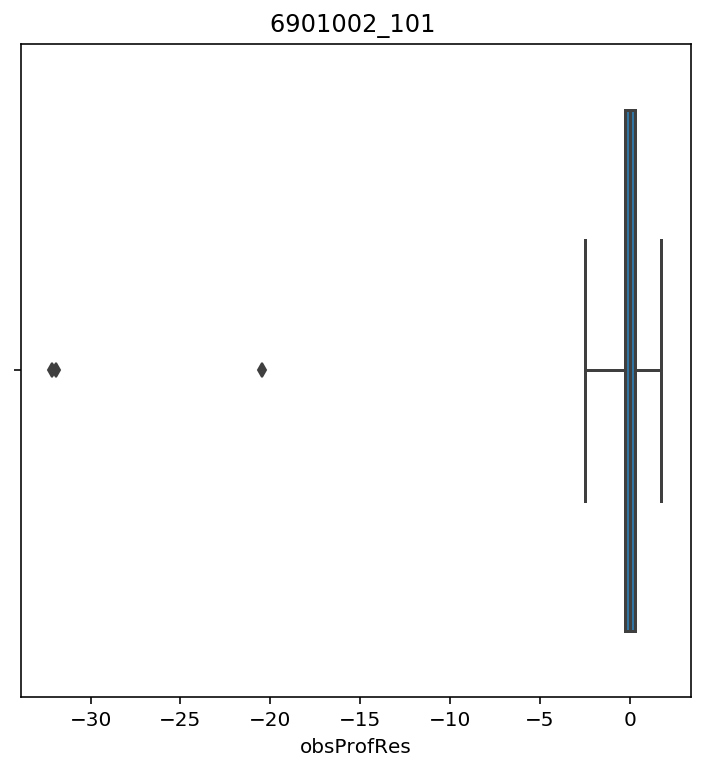

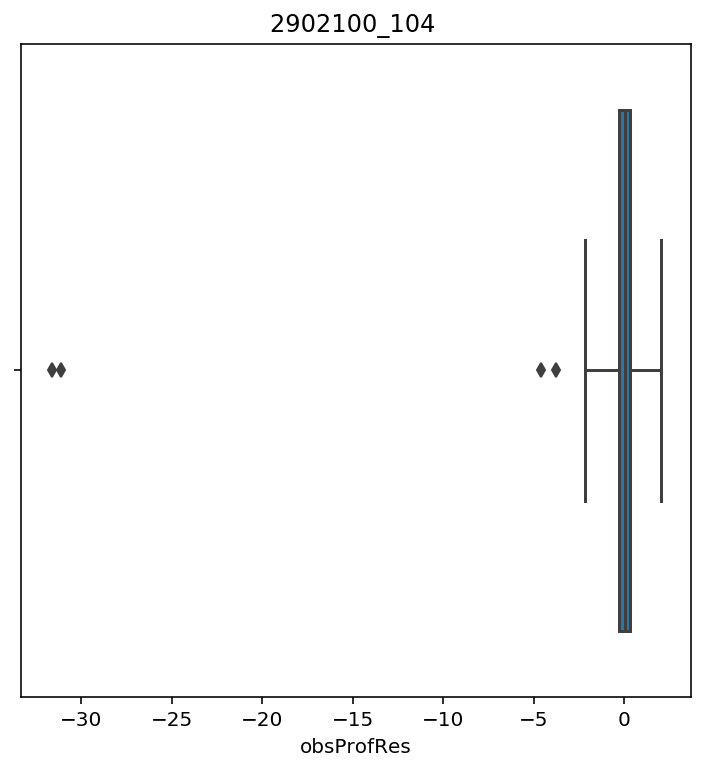

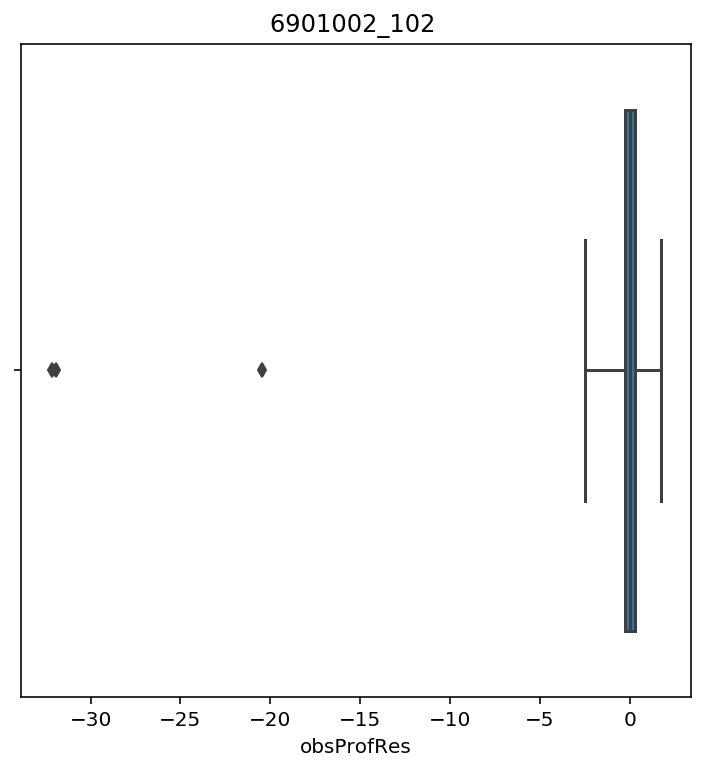

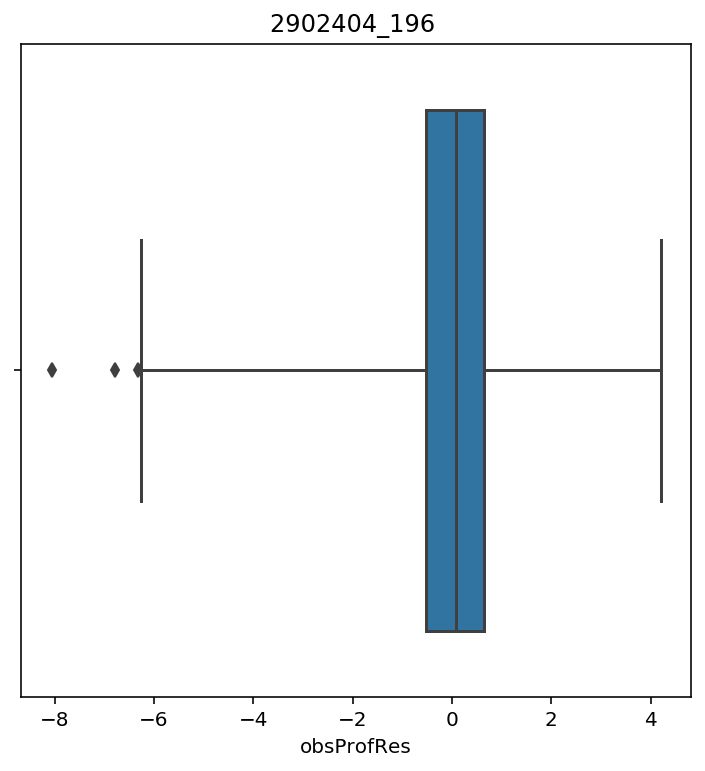

In [185]:
# find highest residuals
suspectDf = df[abs(df['obsProfRes']) > 7]
print(suspectDf.shape)
# get surrounding profiles from each row's lat-lon
window = 5
outTH = 5 # n standard deviations away are considered outliers

outlierProfs = []
for row in suspectDf.itertuples():
    lat = row.profLatAggrSel
    long = row.profLongAggrSel
    
    query = (df['profLongAggrSel'] >= (long - window)) \
            & (df['profLongAggrSel'] <= (long + window)) \
            & (df['profLatAggrSel'] >= (lat - window)) \
            & (df['profLatAggrSel'] <= (lat + window))
    mdf = df[query]
    # construct a hist, with box plot
    
    outliers = []
    outliers = detect_outlier(mdf["obsProfRes"], outTH)
    outlierProfs += mdf['profFloatIDAggrSel'].iloc[outliers].tolist()
    if not len(outliers) == 0:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
        ax = sns.boxplot(x=mdf["obsProfRes"], whis=outTH)
        title = row.profFloatIDAggrSel
        ax.set_title(title)
#

In [188]:
outlierProfs = [x.replace(' ', '') for x in outlierProfs]

In [205]:
profiles = vp.get_profiles_by_id(str(outlierProfs).replace(' ', ''))
if len(profiles) > 0:
    selectionDf = vp.parse_into_df(profiles)
selectionDf.replace(-999, np.nan, inplace=True)

In [207]:
pos = PchipOceanSlices()

TypeError: __init__() missing 1 required positional argument: 'pLevelRange'

In [19]:
keys =  ['dfGrid', 'obsProfHat', 'obsProfRes', 'profFloatIDAggrSel', 'profJulDayAggrSel', 'profLatAggrSel', 'profLongAggrSel', 'stdGrid']